## DEMs coregistration demo
### !! The data for co-registration should be utm projected.
### Taking srtm and tandem dems as example.


In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/Glacier-in-RGI1305'
os.chdir(root_proj)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow
from utils.crop_to_extent import crop_to_extent
from utils.raster_vec import vec2mask
import xdem


In [3]:
path_srtm = 'data/dem-data/srtm-c/SRTMGL1_E_wkunlun_utm.tif'         # master dem
path_tandem = 'data/dem-data/tandem-x/dems_mosaic_wkunlun_utm.tif'   # slave dem
path_l8img = 'data/rsimg/l8_kunlun_20200914.tif'
path_water_jrc = 'data/water_jrc/wkl_water_jrc_utm.tif'   # jrc water map for water mask
path_rgi_1305 = 'data/rgi60-wkunlun/rgi60_1305.gpkg'      # rgi glacier data for glacier mask


### Check dem image

Text(0.5, 1.0, 'tandem (slave)')

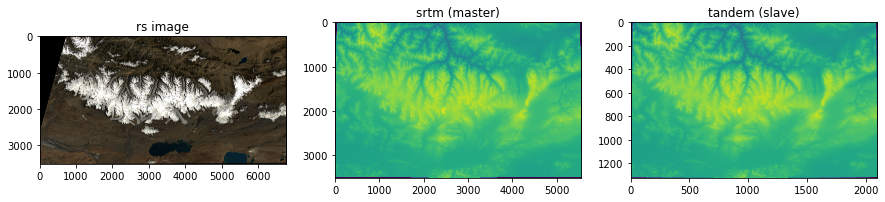

In [4]:
srtm, srtm_info = readTiff(path_srtm)         # master dem
tandem, tandem_info = readTiff(path_tandem)   # slave dem
l8_img, l8_img_info = readTiff(path_l8img) 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); imgShow(l8_img); plt.title('rs image')
plt.subplot(1,3,2); plt.imshow(srtm, vmin=2000, vmax=7000); plt.title('srtm (master)')
plt.subplot(1,3,3); plt.imshow(tandem, vmin=2000, vmax=7000); plt.title('tandem (slave)')



### **2. Co-registration to srtm-c dem by using open-source pybob code.**
##### (Reference: Nuth and Kääb (2011) (https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html))


#### 2.1 DEMs reading and alignment.

In [5]:
srtm_dem = xdem.DEM(path_srtm)     # master dem 
tandem_dem = xdem.DEM(path_tandem).reproject(srtm_dem)   # slave dem
srtm_dem = srtm_dem.reproject(tandem_dem)   # ensure the geo-info are completely the same. some bug for the xdem


#### 2.2 Generate mask image (obtain the stable ground region). 

(3507, 5552)


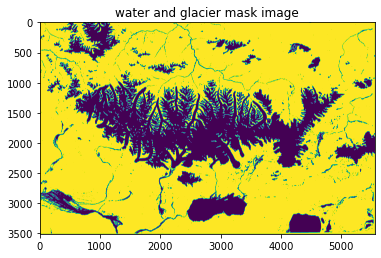

In [6]:
### -- a). water mask based on jrc data
water_jrc = xdem.DEM(path_water_jrc).reproject(srtm_dem)   # master dem 
water_jrc.data = np.ma.masked_where(water_jrc.data>50, water_jrc.data)

### -- b). glacier mask based on rgi-6.0 data
rgi60_mask = vec2mask(path_vec=path_rgi_1305, path_raster=path_srtm, path_save=None)

### -- c). merge the water and glacier masks
mask = np.logical_or.reduce([water_jrc.data[0], rgi60_mask])
mask = ~mask
plt.imshow(mask); plt.title('water and glacier mask image')
print(mask.shape)


#### 2.3 DEMs coregistarion by using NuthKaab method.

In [7]:
nuth_kaab = xdem.coreg.NuthKaab(max_iterations=10, offset_threshold=0.02) # offset_threshold is the distance threshold
nuth_kaab.fit(reference_dem=srtm_dem, dem_to_be_aligned=tandem_dem, inlier_mask=mask, verbose=True)
aligned_dem = nuth_kaab.apply(tandem_dem)


Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = 1.48 - NMAD = 4.84
   Iteratively estimating horizontal shit:


   Progress:   0%|          | 0/10 [00:03<?, ?it/s]

      #1 - Offset in pixels : (-0.07, 0.10)


   Progress:  10%|█         | 1/10 [00:04<00:43,  4.87s/it]

      Median = 1.53 - NMAD = 4.57  ==>  Gain = -5.67%


   Progress:  10%|█         | 1/10 [00:08<00:43,  4.87s/it]

      #2 - Offset in pixels : (-0.02, 0.04)


   Progress:  20%|██        | 2/10 [00:10<00:41,  5.18s/it]

      Median = 1.51 - NMAD = 4.44  ==>  Gain = -2.76%


   Progress:  20%|██        | 2/10 [00:13<00:41,  5.18s/it]

      #3 - Offset in pixels : (-0.01, 0.01)


   Progress:  20%|██        | 2/10 [00:15<01:00,  7.60s/it]


      Median = 1.51 - NMAD = 4.41  ==>  Gain = -0.80%
   Last offset was below the residual offset threshold of 0.02 -> stopping

   Final offset in pixels (east, north) : (-0.098857, 0.149793)
   Statistics on coregistered dh:
      Median = 1.51 - NMAD = 4.41


### **3. Compare the dem difference before and after dems co-registration**

In [8]:
diff_before = tandem_dem - srtm_dem  ## before coregistation
diff_after = aligned_dem - srtm_dem  ## after coregistation
inliers_before = diff_before.data[0][mask].compressed()
med_before, nmad_before = np.nanmedian(inliers_before), xdem.spatialstats.nmad(inliers_before)
inliers_after = diff_after.data[0][mask].compressed()
med_after, nmad_after = np.nanmedian(inliers_after), xdem.spatialstats.nmad(inliers_after)
print(f"Error before: median = {med_before:.2f}; NMAD = {nmad_before:.2f} m")
print(f"Error after: median = {med_after:.2f}; NMAD = {nmad_after:.2f} m")


Error before: median = -1.48; NMAD = 4.84 m
Error after: median = 0.07; NMAD = 4.32 m


Text(0.5, 1.0, 'after co-registration')

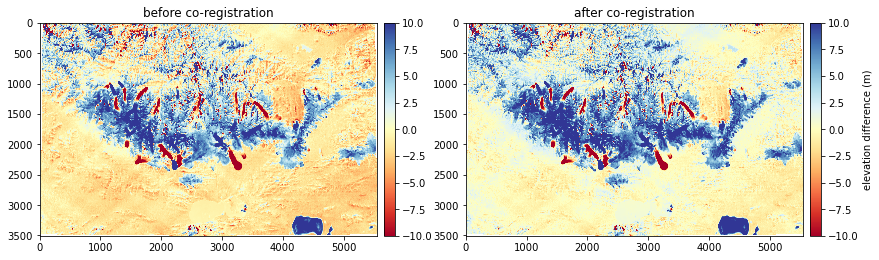

In [9]:
fig1 = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(diff_before.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
plt.title('before co-registration')

plt.subplot(1,2,2)
plt.imshow(diff_after.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
plt.title('after co-registration')
